# EURONEXT LISBON - Forecasting with LSTM

## Instructions
#### Description
This notebook allows to make predictions using LSTM for stock markets retreived with the Yahoo API<br>
Data can be scaled in two ways: 
1) between 0-1  
2) diffence of the logarithms that captures the variation in ragers of previous day.

The model is set to run predictions on the PSI, but you can change the 'ticker' on "Loading data from Yahoo"

#### How-to:
1) Start by running all "Preliminary tasks" including "defining data functions".
2) Run "Linear Univariate model" OR "Diff(log) model"
3) On the predictions section run all code under "Defining methods for predictions"
4) Under Running Predctions run "Linear Model" OR "DiffLog Model

## Preliminary Tasks

#### Importing Libraries

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dense
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


#### Model Parameters

In [94]:
"Parameters of the LSTM models."
#Size of the sliding window
LOOK_BACK = 40
#Number of days where test will be performed
PERIODS_TO_PREDICT = 50
#Size of batch of data in each iteration
BATCH_SIZE = 25
#Number of iteration the model will do during traing
EPOCHS=50
#Range of the Model adjstment 
LEARN_RATE=0.001
#Percentage of data used for training validation
VALIDATION_SPLIT=0.2
#Nubmer of nodes in the first LSTM layer
NUMBER_NEURONS=50
#Nubmer of LSTM layers
NUMBER_OF_LAYERS=2;
#5y or 10y
PERIOD='5y'

#### Loading data from Yahoo

In [67]:
#df = pd.DataFrame(yf.Ticker('PSI20.LS').history(period = PERIOD))
#df=df.truncate(after="2023-02-01")
#df.to_csv('stocks10y.csv')


In [89]:
def load_df_portugal():
    return pd.read_csv('stocks.csv', index_col=0, parse_dates=True) if PERIOD=='5y' else pd.read_csv('stocks10y.csv', index_col=0, parse_dates=True)    

### EDA - Exploratory Data Analysis

In [69]:
df=load_df_portugal()
#sns.set(rc={'figure.figsize':(15.27,15.27)})

<AxesSubplot:title={'center':'PSI20 Close Daily correlation'}, xlabel='y(t)', ylabel='y(t + 1)'>

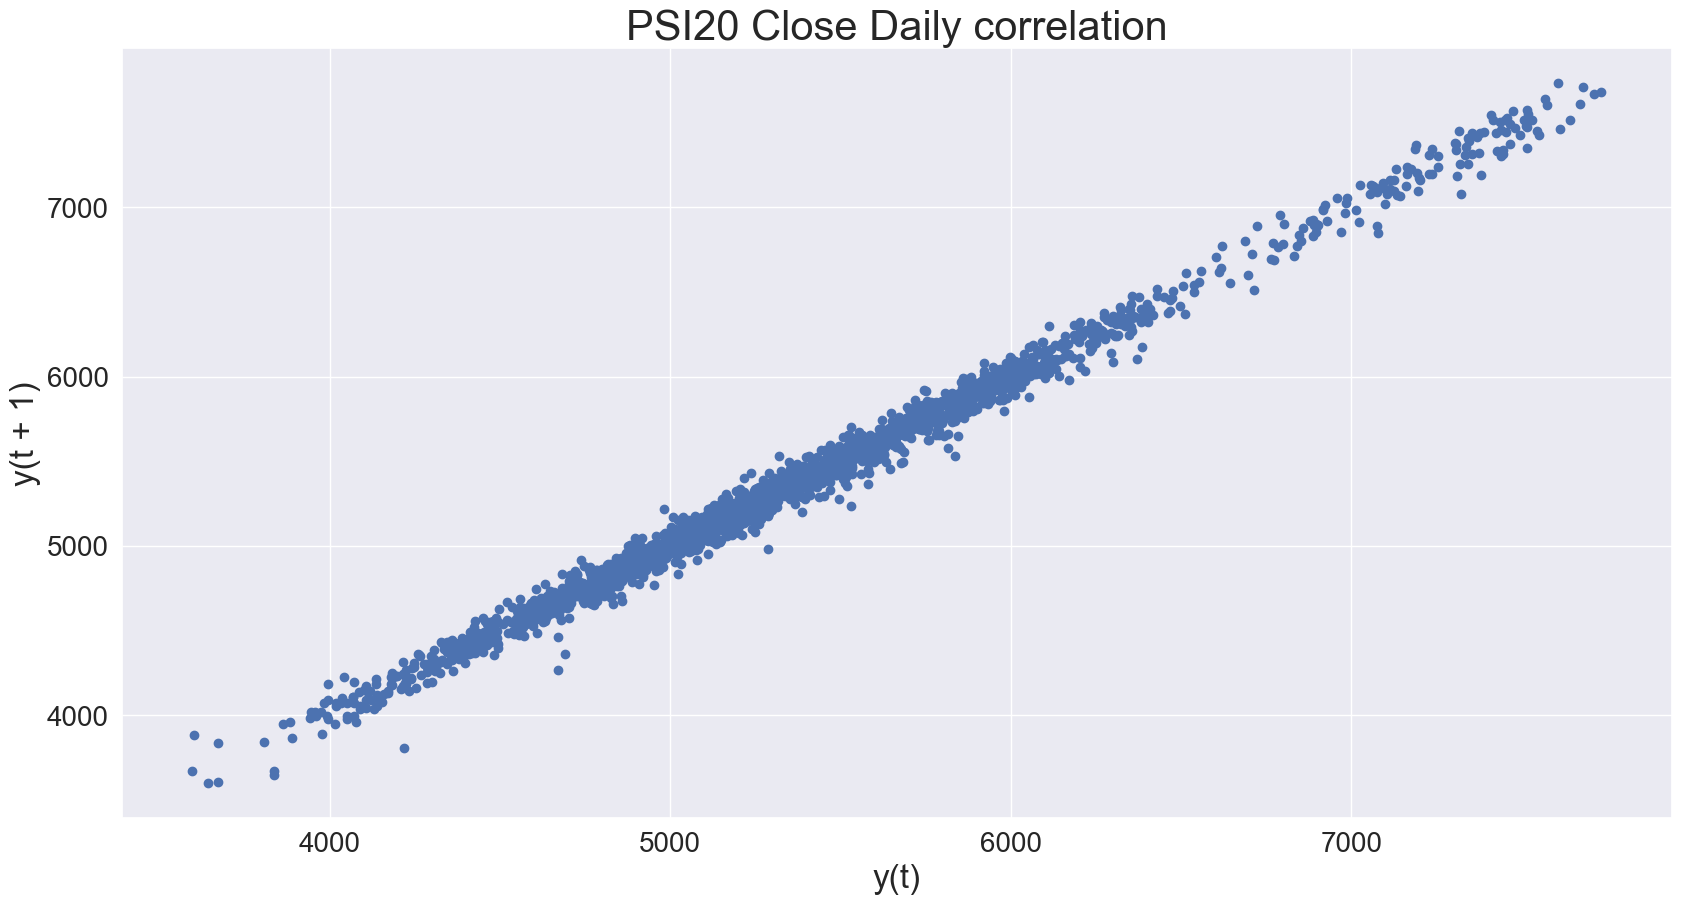

In [70]:
from pandas.plotting import lag_plot
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("PSI20 Close Daily correlation", fontsize=30)
lag_plot(df['Close'], lag=1)


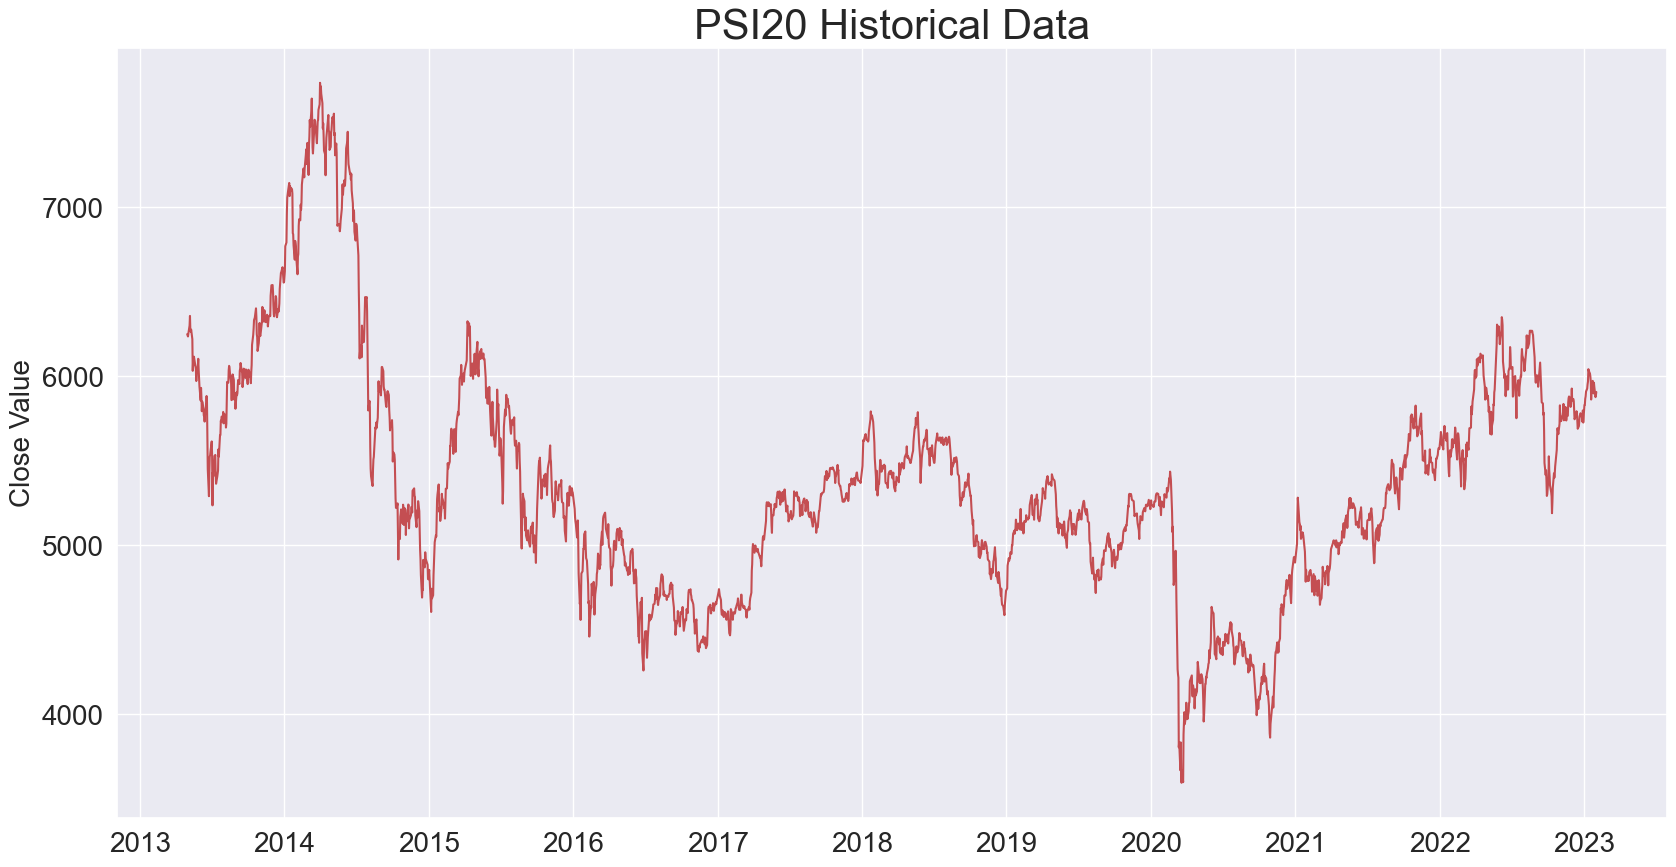

In [71]:
import seaborn as sns
plt.plot(df["Close"], 'r', label='PSI20 Daily Closing Values')
plt.title("PSI20 Historical Data", fontsize=30)
plt.ylabel('Close Value', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
import seaborn as sns
sns.set(font_scale=2)
#sns.set(rc={'figure.figsize':(15.27,15.27)})
#plt.hist(accuracies3)
#plt.show()
plt.show()  




In [72]:
df.describe()


,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,2487.000000,2487.000000,2487.000000,2487.000000,2.487000e+03,2487.0,2487.0
mean,5359.785471,5393.028949,5322.579992,5357.714244,1.052302e+08,0.0,0.0
std,681.798154,684.869361,676.923560,681.551797,1.969420e+08,0.0,0.0
min,3554.699951,3613.669922,3500.020020,3596.080078,0.000000e+00,0.0,0.0
25%,4943.090088,4975.674805,4902.780029,4933.604980,0.000000e+00,0.0,0.0
50%,5280.209961,5310.620117,5255.109863,5283.649902,5.779850e+07,0.0,0.0
75%,5706.635010,5747.599854,5667.614990,5705.209961,1.050409e+08,0.0,0.0
max,7770.290039,7790.560059,7669.669922,7734.950195,3.555048e+09,0.0,0.0


### Defining data functions.

##### Data Preparation

In [73]:
"Dropping unwanted columns from the data retrieved"
def selectData(datframe=df) :
    data = datframe[["Close"]]
    size = len(data) - PERIODS_TO_PREDICT
    return data, size

In [74]:
# Splits Data into Train Data and Test Data
def divideData(data, size) : 
    
    train_data=data.values[0:size,:]
    test_data=data[size-LOOK_BACK:].values.reshape(-1,1)
    
    return train_data,test_data

#### Scalers

In [75]:
# Scale Data between 0 and 1 
def scaleData(data,scaler) :
    d1=data.copy()
    temp = scaler.fit_transform(d1[:, 0].reshape(-1,1))
    d1[:,0] = temp.squeeze()
    return d1
 

In [76]:
def diffLogData (data) : 
    data = np.reshape(data,(data.shape[1], data.size))
    return np.diff(np.log(data)).T
    #return np.transpose(np.diff(np.log(data)))

In [77]:
def undiffLogData (actualData, diffLoggedData) :
    "Data is the array of logarithmic Differences and v0 is the actual prices on the period"
    #TODO in the data array add a "1" on position 0. - Concatenate.
    
    temp = np.exp(np.log(actualData[:-1]) - diffLoggedData)

    return np.concatenate((actualData[0:1], temp))

#### Train/Test Vector Creators

In [78]:
#%% Creates a vectors for training (2D numpy arrays)
def createTrainVector(data) :
    "For each predicted result creates a vector with x values, wher x is the LOOK_BACK"
    
    x_train=[]

    for i in range(LOOK_BACK,len(data)):
        x_train.append(data[i-LOOK_BACK:i,0])
    
    return np.asarray(x_train)

In [79]:
#%% Creates a vectors with target data
def createTargetVector(data) :
    return np.asarray(data[LOOK_BACK:])

In [80]:
# Creates an array for predicting PERIODS_TO_PREDICT
def createTestVector(data) :
    "For each predicted result creates a vector with x values, where x is the LOOK_BACK"
    
    X_test=[]
    
    for i in range(LOOK_BACK,data.shape[0]):
        X_test.append(data[i-LOOK_BACK:i,0])
    X_test=np.array(X_test)
    
    return np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

#### LSTM Model

In [81]:
#%% Creates a LSTM Sequential model
def createLstmModel (data) : 

    input_shape=(np.shape(data)[1],1)
    
    lstm_model=Sequential()

    if (NUMBER_OF_LAYERS==1):
        lstm_model.add(LSTM(units=NUMBER_NEURONS, input_shape=input_shape))
    else:
        if(NUMBER_OF_LAYERS==2):
            lstm_model.add(LSTM(units=NUMBER_NEURONS, return_sequences=True, input_shape=input_shape))
            #lstm_model.add(Dropout(0.01))
            lstm_model.add(LSTM(units=int(NUMBER_NEURONS/2)))
        else:
            lstm_model.add(LSTM(units=NUMBER_NEURONS, return_sequences=True, input_shape=input_shape))
            lstm_model.add(LSTM(units=int(NUMBER_NEURONS/2),return_sequences=True))
            lstm_model.add(LSTM(units=int(NUMBER_NEURONS/4)))

    #lstm_model.add(Dropout(0.01))
    
    # For single or multiple output (regression)
  
        lstm_model.add(Dense(units=1))
        lstm_model.compile(loss='mse',
                    optimizer=Adam(learning_rate=LEARN_RATE)
                    )
        return lstm_model

In [82]:
#%% Trains the model -  data
def trainLstmModel (model, x_train, y_train,epoch=EPOCHS) :
    return model.fit(x_train,
                y_train,
                batch_size=BATCH_SIZE,
                epochs=epoch,
                validation_split=VALIDATION_SPLIT,
                verbose='auto')

In [83]:
def plotHistory(history, yaxis="MAE", title="") :
    plt.plot(history.history['loss'], label='Train Data')
    plt.plot(history.history['val_loss'], label='Validation Data')
    plt.xlabel("EPOCHS", fontsize=20)
    plt.ylabel(yaxis, fontsize=20)
    plt.title(title, fontsize=30, loc="center")
    plt.legend(fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()




## == RUNNING THE MODEL ==

#### Linear Univariate model

This model gives an estimate the PSI-20 value  based on the quotations of a sliding window of the [LOOK_BACK] days, before the estimated value.

In [90]:
#df=df.truncate(after=pd.Timestamp('2021-08-01 00:00:00+00:00'))

#Preparation of the data
global_data, size_train_data = selectData() 
train_data,test_data = divideData(global_data, size_train_data)

#Scaling the Data
scaler=MinMaxScaler(feature_range=(0,1))
scaled_train_data=scaleData(train_data,scaler)
scaled_test_data=scaleData(test_data,scaler)

#Preparing traing and testing arrays
x_train_data = createTrainVector(scaled_train_data)
y_train_data = createTargetVector(scaled_train_data)
X_test = createTestVector(scaled_test_data)


In [91]:
print("x data\n")
print(x_train_data)
print("\ny data - target\n")
print(y_train_data)

x data

[[0.64086088 0.63761599 0.64207378 ... 0.44836868 0.40947402 0.44309192]
 [0.63761599 0.64207378 0.65322897 ... 0.40947402 0.44309192 0.46610545]
 [0.64207378 0.65322897 0.66696463 ... 0.44309192 0.46610545 0.46785713]
 ...
 [0.45697493 0.43969732 0.44647696 ... 0.53690975 0.53195187 0.51762197]
 [0.43969732 0.44647696 0.43225808 ... 0.53195187 0.51762197 0.52428317]
 [0.44647696 0.43225808 0.40984611 ... 0.51762197 0.52428317 0.52431219]]

y data - target

[[0.46610545]
 [0.46785713]
 [0.47375244]
 ...
 [0.52428317]
 [0.52431219]
 [0.54375463]]


In [95]:
#Model definition and training
lstm_model = createLstmModel(x_train_data)
print(lstm_model.summary())
history=trainLstmModel(lstm_model, x_train_data, y_train_data, epoch = 50)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 40, 50)            10400     
                                                                 
 lstm_13 (LSTM)              (None, 25)                7600      
                                                                 
 dense_6 (Dense)             (None, 1)                 26        
                                                                 
Total params: 18,026
Trainable params: 18,026
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
77/77 [==============================] - 7s 43ms/step - loss: 0.0209 - val_loss: 0.0017
Epoch 2/50
77/77 [==============================] - 2s 32ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 3/50
77/77 [==============================] - 2s 31ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 4/50
7

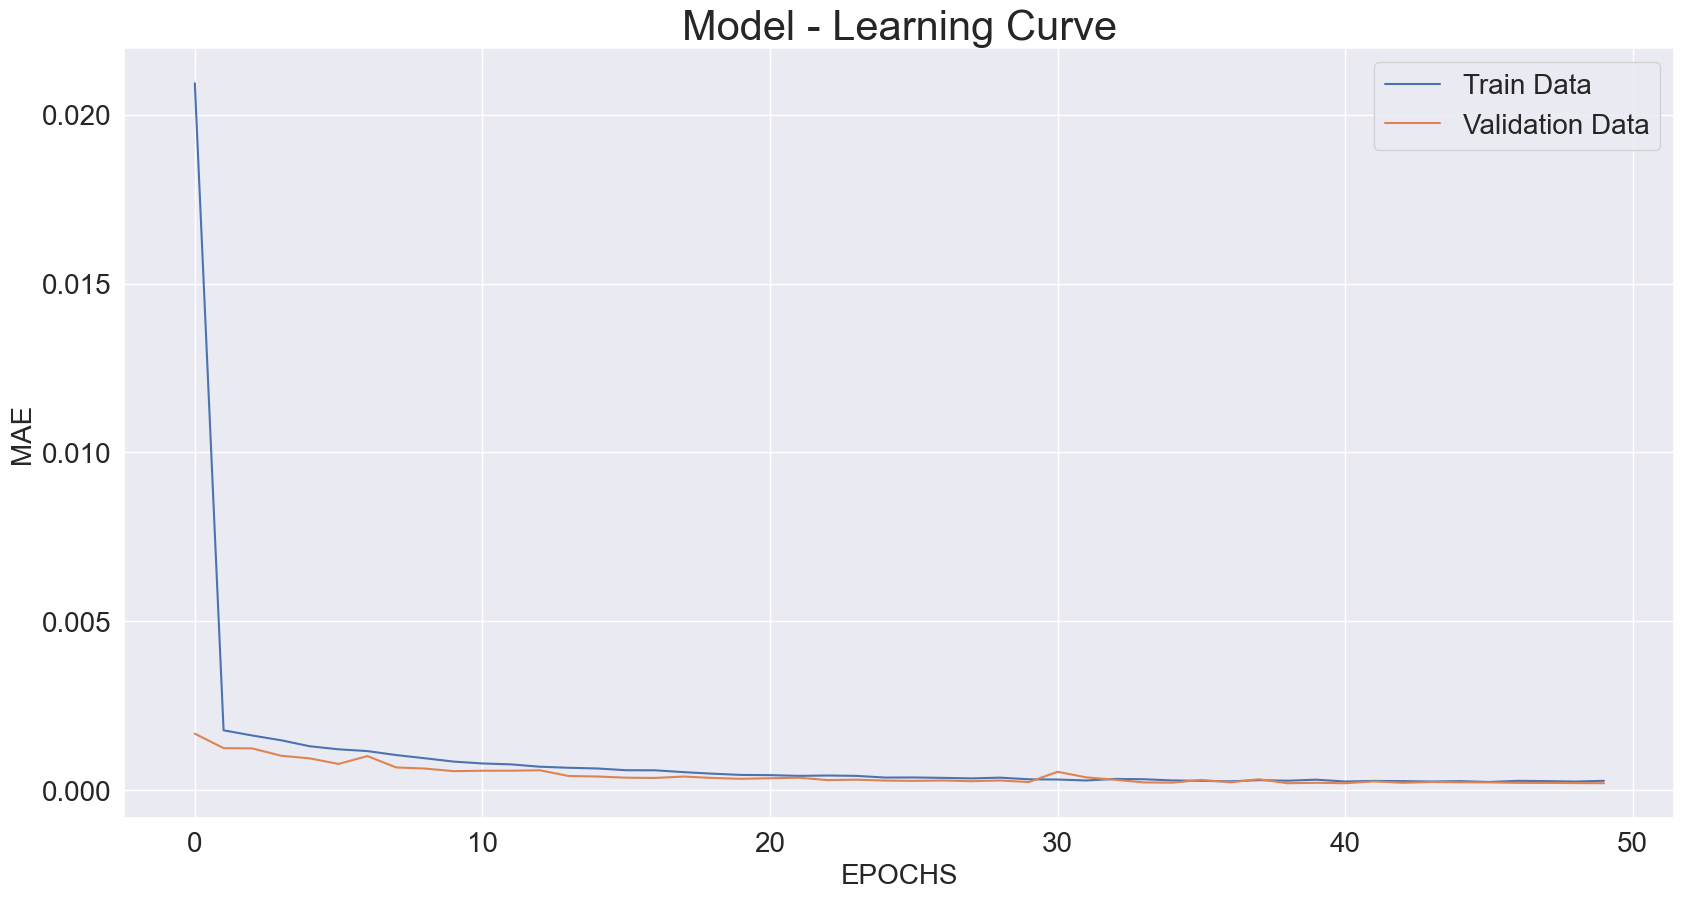

In [96]:

plotHistory(history, title="Model - Learning Curve")

In [122]:

lstm_model.save('.\models\my_model.h5')  # creates a HDF5 file 'my_model.h5'

#### Diff(log) model

This model works in similar way as the Linear univariate model. The difference is that the data is based on the difference of the logaritms between two consecutive days, providing insights on the daily variation in relation to the previous day.

In [31]:
#df=df.truncate(after=pd.Timestamp('2021-08-01 00:00:00+00:00'))

#Preparing traing and testing arrays
global_data, size_train_data = selectData(datframe=df) 
train_data,test_data = divideData(global_data, size_train_data)


#"difflogging" the Data
scaled_train_data=diffLogData(train_data)
scaled_test_data=diffLogData(test_data)

#Preparing traing and testing arrays
x_train_data = createTrainVector(scaled_train_data)
y_train_data = createTargetVector(scaled_train_data)
X_test = createTestVector(scaled_test_data)


In [32]:

lstm_difflog_model = createLstmModel(x_train_data)
print(lstm_difflog_model.summary())
history=trainLstmModel(lstm_difflog_model, x_train_data, y_train_data)      


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 40, 50)            10400     
                                                                 
 lstm_5 (LSTM)               (None, 25)                7600      
                                                                 
 dense_2 (Dense)             (None, 1)                 26        
                                                                 
Total params: 18,026
Trainable params: 18,026
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
77/77 [==============================] - 7s 41ms/step - loss: 1.6193e-04 - val_loss: 1.2258e-04
Epoch 2/20
77/77 [==============================] - 2s 30ms/step - loss: 1.4739e-04 - val_loss: 1.1550e-04
Epoch 3/20
77/77 [==============================] - 2s 30ms/step - loss: 1.4852e-04 - val_loss:

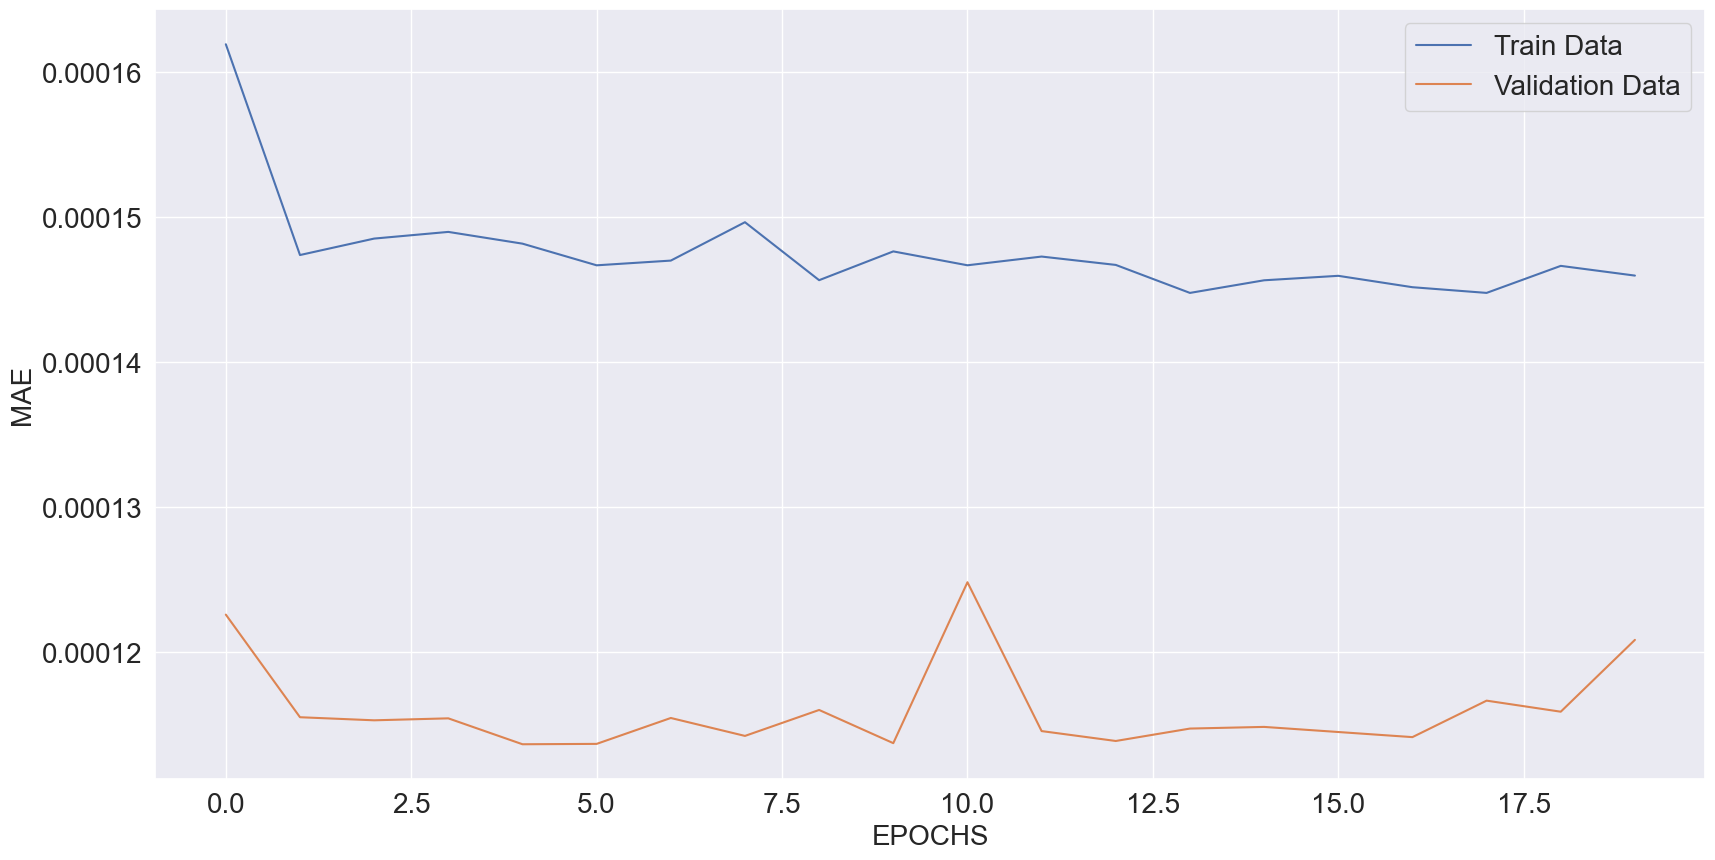

In [34]:
                        
plotHistory(history)



## == PREDICTIONS ==

### Defining methods for predictions

##### Evaluate Predictions:

In [53]:
def testPredictionsScore(predicted, data=test_data):
    
    if (type=="categorical"):
        data = data[LOOK_BACK+1:,0]
    else:
        data = data[LOOK_BACK:,0]
 

    print('==================================')
    testScore = np.sqrt(mean_squared_error(data, predicted))
    print('Test Score: %.2f RMSE' % (testScore))
    print('==================================')    

#### Plotting the results

In [36]:
def fillDataForPlotting (history,predicted,benchmark): 
    #Setting Vectors for plotting
    tr_data = history.iloc[:size_train_data]
    tt_data = history.iloc[size_train_data:]
    tt_data = tt_data.assign(Predictions=predicted)
    if (not benchmark.empty):
        tt_data = tt_data.assign(Day_Before=benchmark)
    return tr_data,tt_data

In [37]:
def plotAllHistory (train_data,test_data,title): 
    #Plotting all history
    plt.plot(train_data["Close"], label='Historical Data')
    plt.plot(test_data["Close"], label='Observed Values', color="blue")
    plt.plot(test_data["Predictions"], label='Predicted Values', color="orange")
    #plt.plot(test_data["Day_Before"], label='Previous day', color="green")
    plt.title(title + " - All history", fontsize=30)
    plt.xlabel('Time', fontsize=15)
    #plt.legend(fontsize=20, loc=3)
    plt.legend(fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()  

In [38]:
def plotPredictedPeriod (test_data, title,printBenchmark):
    #Plot predicted Period
    plt.plot(test_data["Close"], label='Observed Values', color="blue")
    plt.plot(test_data["Predictions"], label='Predicted Values', color="orange")
    if printBenchmark:
        plt.plot(test_data["Day_Before"], label='Previous day', color="green")
    plt.title(title + " - Predicted Period", fontsize=30)
    plt.xlabel('Time', fontsize=25)
    plt.ylabel('Closing Value',fontsize=25)
    #plt.legend(fontsize=20, loc=3)
    plt.legend(fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()  


In [39]:
def plotResults(history=global_data, predicted="",benchmark=pd.DataFrame(), title=""):
    tr_data,tt_data = fillDataForPlotting(history,predicted,benchmark);
    plotAllHistory(tr_data,tt_data, title);
    #Only prints benchmark if not empty
    plotPredictedPeriod(tt_data,title,not benchmark.empty);


### Running Predictions

##### Linear Model

In [56]:
#Linear model
predicted_stock_price=lstm_model.predict(X_test)
predicted_stock_price=scaler.inverse_transform(predicted_stock_price)


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 15ms/step


In [58]:
testPredictionsScore(predicted_stock_price, test_data)


Test Score: 49.56 RMSE


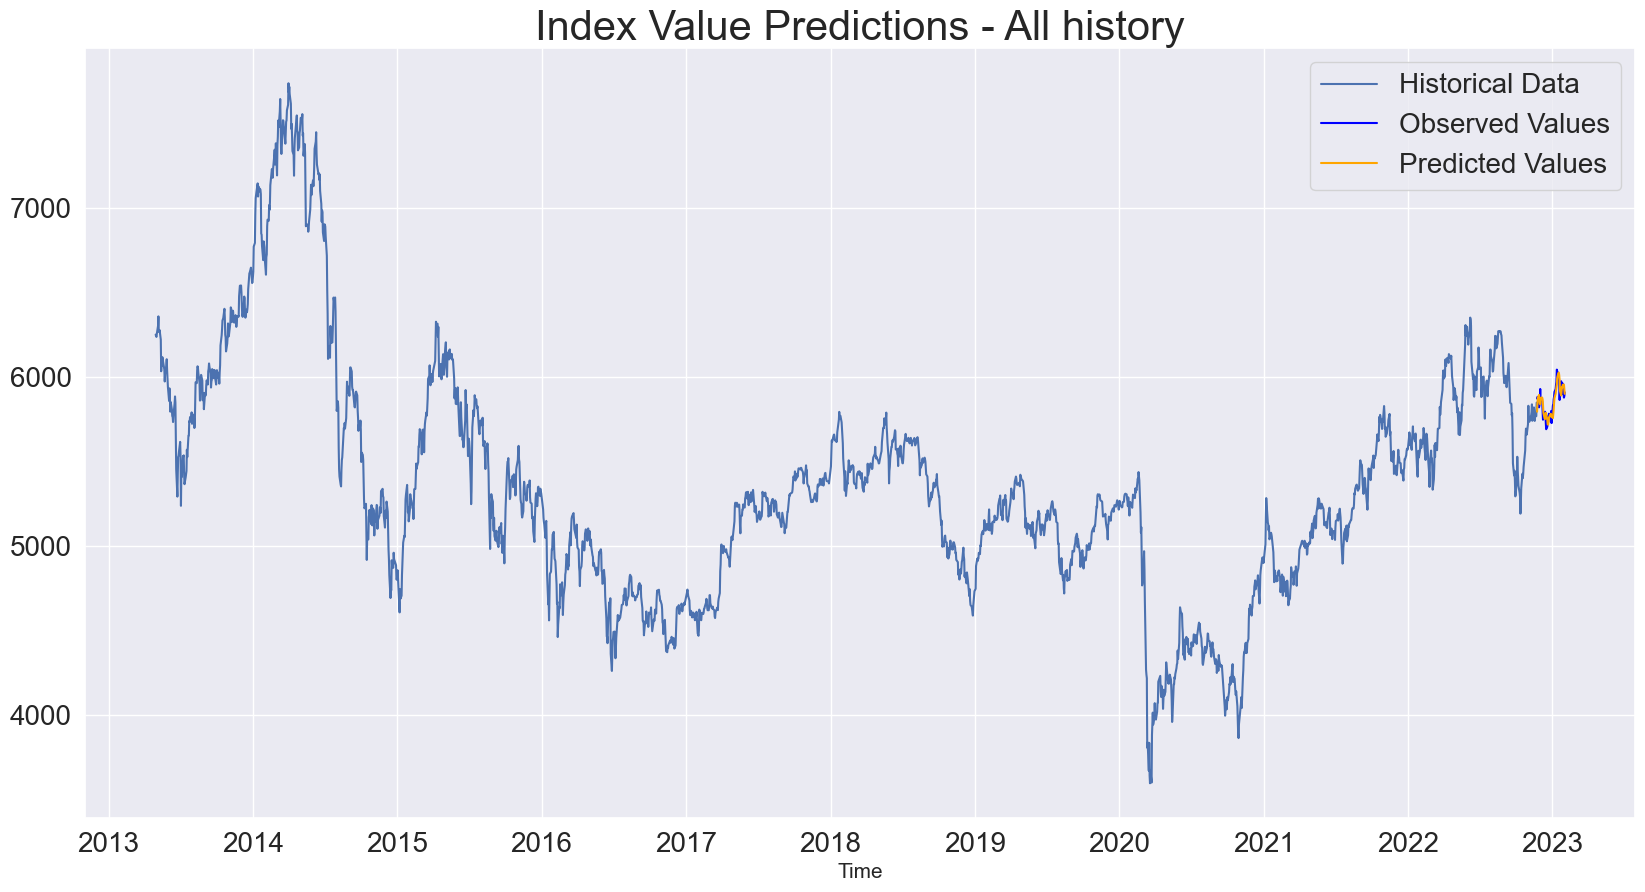

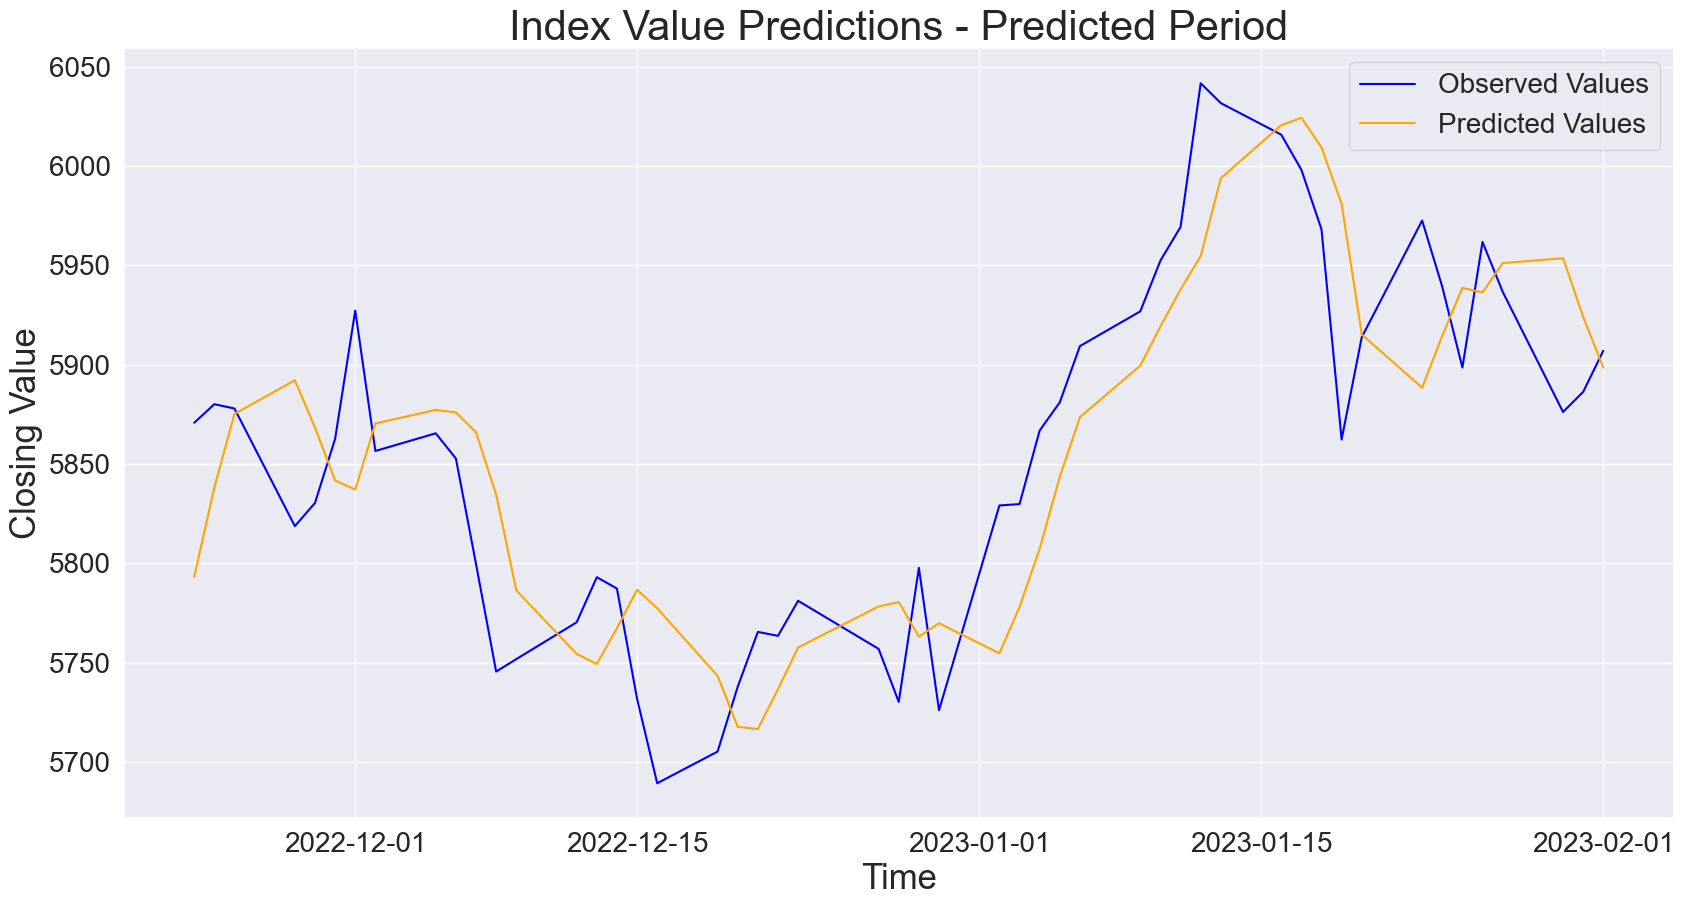

In [62]:
plotResults(predicted=predicted_stock_price, title="Index Value Predictions")

##### DiffLog Model


In [60]:
#Difflog Model
diff_logged_predictions=lstm_difflog_model.predict(X_test)

2/2 [==============================] - 0s 12ms/step


In [61]:
#Transforms the difflogeed data in actual predicted stock prices
predicted_stock_price = undiffLogData(test_data[LOOK_BACK:], diff_logged_predictions);


ValueError: operands could not be broadcast together with shapes (49,1) (50,1) 

In [59]:
testPredictionsScore(predicted_stock_price,test_data)
#testDayBeforeScore()

Test Score: 49.56 RMSE


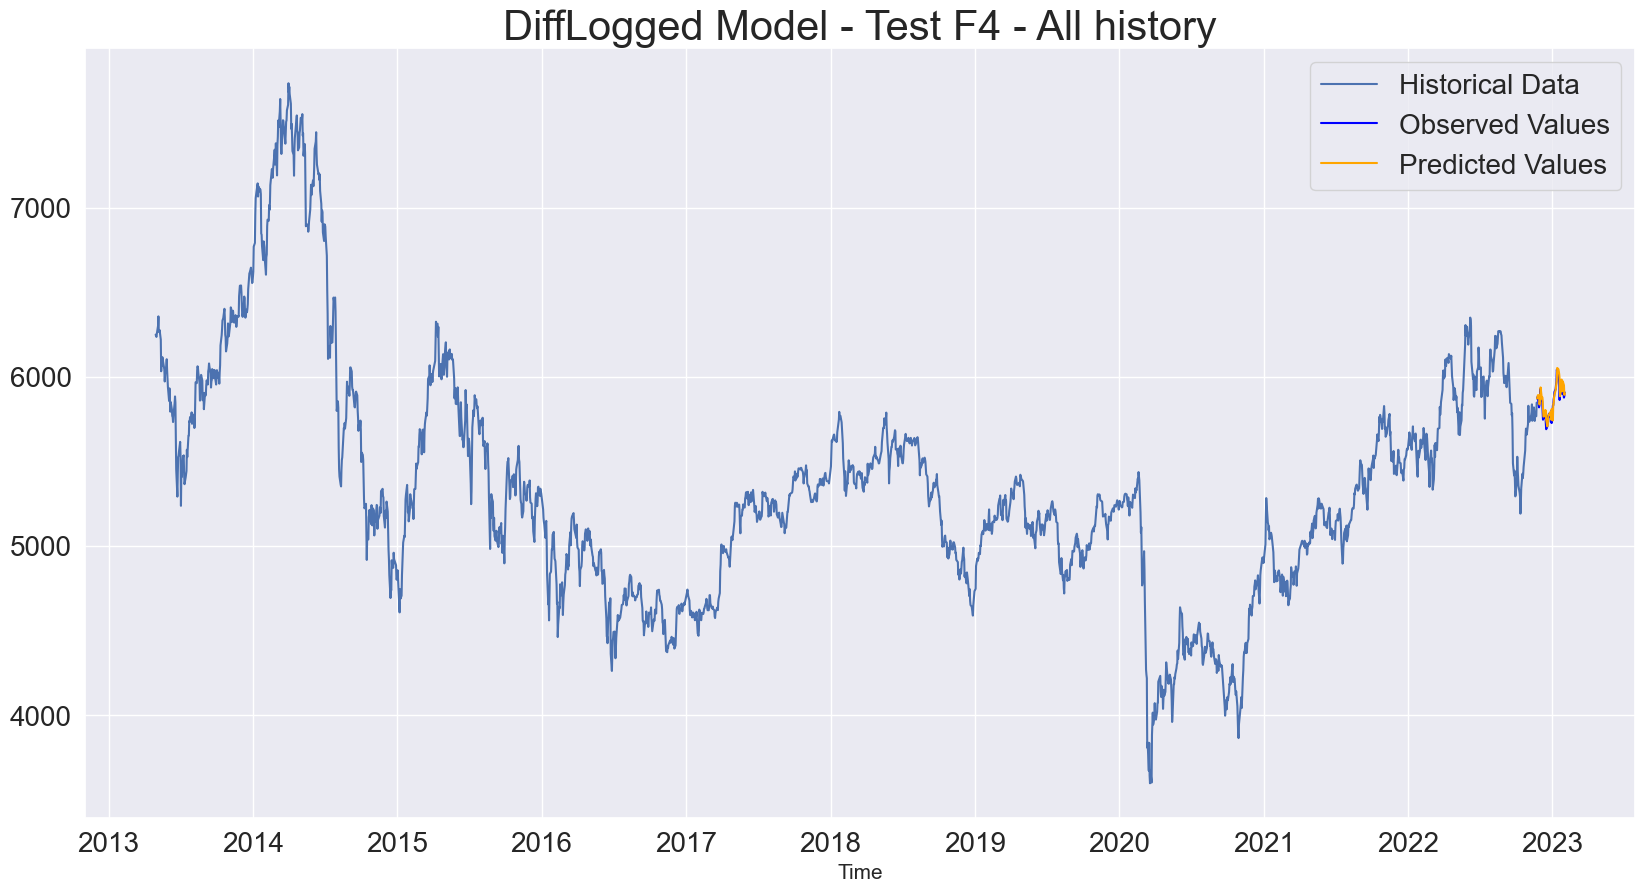

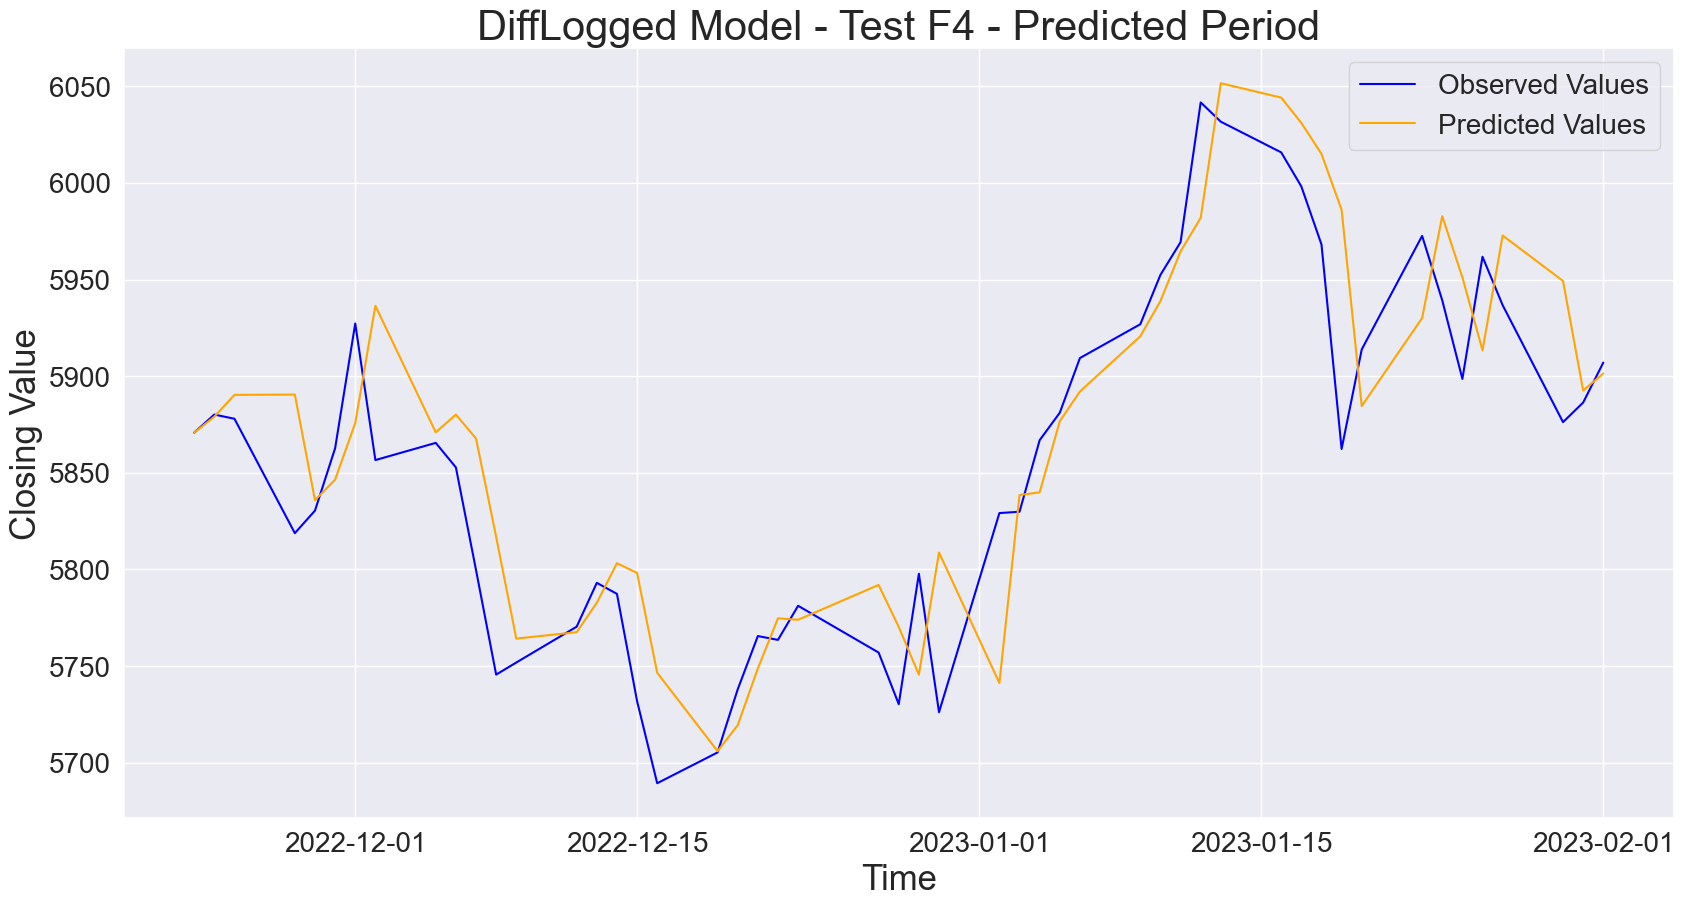

In [43]:
plotResults(history=global_data, predicted=predicted_stock_price, title="DiffLogged Model - Test F4")

# Clear All

In [140]:
lstm_model.save('.\models\my_model.h5')  # creates a HDF5 file 'my_model.h5'
globals().clear()


<function dict.clear>